In [1]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [2]:
def merge_forecasts(forecasts):
    result = np.zeros((forecasts.shape[0],forecasts.shape[0]+forecast_num_time_step))
    for i, el in enumerate(forecasts):
        result[i][i:i+forecasts.shape[2]] = el.flatten()
    
    total_mean = []
    for i in log_progress(range(len(result))):
        mean = [0,1]
        for el in result[:,i]:
            if el != 0:
                mean[0] += el
                mean[1] += 1
        total_mean.append(mean[0]/(mean[1]-1))

    return np.array(total_mean)

In [3]:
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

import numpy as np
 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

# import theano
# theano.config.compute_test_value = "ignore"

Using TensorFlow backend.
/Users/stas/Documents/NTC/crm-master/crm/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/stas/Documents/NTC/crm-master/crm/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/stas/Documents/NTC/crm-master/crm/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

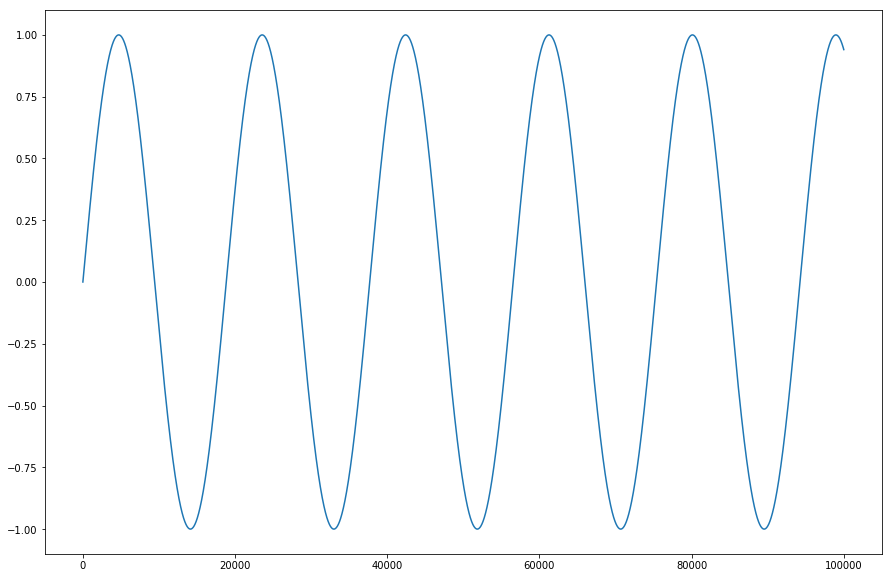





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [4]:
num_time_step = 20
forecast_num_time_step = 20

time_series_len = 100000
batch_size = 50
time_series = [np.sin(x/3) for x in np.linspace(0, 100, time_series_len)]

plt.figure(figsize=(15,10))
plt.plot(time_series)
plt.show()

X_train = []
y_train = []
for i in range(len(time_series[num_time_step:-forecast_num_time_step])):
    X_train.append(time_series[i:i+num_time_step])
    y_train.append(time_series[i+num_time_step:i+num_time_step+forecast_num_time_step])

X_train = np.array(X_train).reshape((time_series_len - num_time_step - forecast_num_time_step,num_time_step, 1))
y_train = np.array(y_train)

model = Sequential()
model.add(LSTM(128, input_shape=(num_time_step, 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, input_shape=(num_time_step, 1)))
model.add(Dense(forecast_num_time_step, activation='linear'))

model.compile(optimizer=Adam(), 
              loss='mean_squared_error')

In [5]:
history = model.fit(X_train, y_train, 
          epochs = 1, 
          batch_size = batch_size, 
          verbose=1, 
#           validation_data=(X_train, y_train),
#           callbacks=[reduce_lr, checkpointer],
          shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1
99960/99960 [==============================] - 66s 661us/step - loss: 3.6573e-04


In [6]:
model.predict(np.array(time_series[i:i+num_time_step]).reshape((-1,num_time_step, 1)))

array([[0.9466181 , 0.9478444 , 0.94609797, 0.9462934 , 0.94701135,
        0.935873  , 0.9426864 , 0.9448991 , 0.94315165, 0.9390591 ,
        0.9414644 , 0.9396256 , 0.9398314 , 0.9416679 , 0.9394698 ,
        0.9412559 , 0.9397066 , 0.94028234, 0.9458897 , 0.9366218 ]],
      dtype=float32)

In [ ]:
%%time 
X_test = []
y_test = []
for i in log_progress(range(len(time_series[num_time_step:-forecast_num_time_step]))):
    X_test.append(model.predict(np.array(time_series[i:i+num_time_step]).reshape((-1,num_time_step, 1))))

X_test = np.array(X_test)

plt.figure(figsize=(15,10))
plt.plot(merge_forecasts(X_test).flatten())
plt.plot(time_series[num_time_step:-forecast_num_time_step])
plt.legend(['pred','true'], loc='best')
plt.show()

In [ ]:
%%time 
X_test = []
for i in log_progress(range(len(time_series[-1*num_time_step:]))):
    X_test.append(model.predict(np.array(time_series[i:i+num_time_step]).reshape((-1,num_time_step, 1))))

# X_test.append(model.predict(np.array(time_series[-num_time_step:]).reshape((-1,num_time_step, 1))))
X_test = np.array(X_test)

plt.figure(figsize=(15,10))
plt.plot(merge_forecasts(X_test).flatten())
plt.plot(time_series[-1*num_time_step:])
plt.legend(['pred','true'], loc='best')
plt.show()